In [45]:
# Importing Required Libraries
import sys
import numpy as np # numpy for vector calculations
import matplotlib.pyplot as plt # For visualization and Results
import torch # import Pytorch
import gymnasium_robotics
import torch.nn as nn # Neural Network
import torch.optim as optim #Neural Network Optimizer
from torch.distributions import Categorical, Normal # Categorical - Discrete Action Space , Normal - Continious Action Space
import gymnasium as gym  # enviroments or MDP
from collections import deque # to compute moving averages
import pickle #storing Policies
from typing import List, Tuple, Dict #readability and type safety
import time #benchmarking\logging

In [46]:
# Here we do seeding to ensure that during an episode run we are starting with the same inital state from the distribution Porivded by the MDP
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


In [47]:
# Check if CUDA GPU is availible , Switch to GPU if exist else fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Here we define our discrete  policy class that is going to be a Multiple Layer Perceptron with Relu Activation with a final Softmax Layer to assign Probabilities to all possible actions for a particular state s in the state space we will be using it for Cartpole and lunarlander forward() gives the raw logits of the data and in the get_action() a softmax layers is applied on it and an action is sampled from it



In [48]:
class Discrete(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_sizes: List[int]):
        super(Discrete, self).__init__()
        
        layers = []
        input_dim = state_dim
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU()) 
            input_dim = hidden_size
        
        layers.append(nn.Linear(input_dim, action_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, state):
        return self.network(state)
    
    def get_action(self, state):
        state = torch.FloatTensor(state).to(device)
        logits = self.forward(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

the Neural Network here with hidden layers defined as per enviroments which are defined later for eg for Cartpole it is really light and medium to heavy for lunar lander the forward functions give logits or raw score for all actions in action space and get_action apply softmax and samples an action for the particular state in the Next code block is the implementation of Continous Policy which  draws samples from a gaussian distribution the Multilayer Perceptron Here will return and the mean and standard deviation of the distribution and get_action uses this distribution to get an action the case of mulidimensiona action is also handled here where in the probability of action with be the product of probablitites of its individual dimensions or sum in case of log_prob forward() return the mean and std of a fitted gaussian distribution get_action()

In [49]:
class Continuous(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_sizes: List[int]):
        super(Continuous, self).__init__()
        
        layers = []
        input_dim = state_dim
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())
            input_dim = hidden_size
        
        layers.append(nn.Linear(input_dim, action_dim))
        self.mean_network = nn.Sequential(*layers)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
    
    def forward(self, state):
        mean = self.mean_network(state)
        std = torch.exp(self.log_std)
        return mean, std
    
    def get_action(self, state):
        state = torch.FloatTensor(state).to(device)
        mean, std = self.forward(state)
        dist = Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        return action.cpu().numpy(), log_prob

Next we define a neural netwrok for estimating the value function this will act as our baseline function and using this the variance of the rewarsd will be reduced the procedre for that i.e. the TD Residual and the Generalized Advantage Estimator is in the class VPGAgentWithGAE the forward function computes the value estimates

In [50]:
class Value(nn.Module):
    def __init__(self, state_dim: int, hidden_sizes: List[int]):
        super(Value, self).__init__()
        
        layers = []
        input_dim = state_dim
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())
            input_dim = hidden_size
        
        layers.append(nn.Linear(input_dim, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, state):
        return self.network(state).squeeze(-1)

Vanilla Policy Gradient (VPG) agent
This agent uses a neural network policy (MLP) that takes the current state
𝑠
s as input and outputs a distribution over actions (categorical for discrete actions, Gaussian for continuous actions).
It rolls out trajectories in the environment by sampling actions from the policy.
It computes discounted rewards-to-go for each state-action pair in the trajectory.
It computes losses MSE for Value network update and the advantage functions for the gardient ascent
Finally, it performs gradient ascent on the policy objective using the log-likelihood trick, updating the policy parameters to maximize expected returns as well updates the value network.

reset_trajectory() resets the stored values and empties the list select_action() uses the policy to sample an action store_transition() stores the current stae action rewards and the next state compute_gae() estimates the value function using the realtion given in the comments and update() uses these estiamtes to update the polict network as wellas the value network









In [51]:
class VPGAgentWithGAE:
    """VPG Agent with Generalized Advantage Estimation (GAE)"""
    
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        is_continuous: bool,
        lr_policy: float = 1e-3,
        lr_value: float = 1e-3,
        gamma: float = 0.99,
        lam: float = 0.95,
        hidden_sizes_policy: List[int] = None,
        hidden_sizes_value: List[int] = None
    ):
        self.gamma = gamma
        self.lam = lam  # GAE lambda parameter
        self.is_continuous = is_continuous
        
        if hidden_sizes_policy is None:
            hidden_sizes_policy = [64, 64]
        if hidden_sizes_value is None:
            hidden_sizes_value = [64, 64]
        
        
        if is_continuous:
            self.policy = Continuous(state_dim, action_dim, hidden_sizes_policy).to(device)
        else:
            self.policy = Discrete(state_dim, action_dim, hidden_sizes_policy).to(device)
        
        
        self.value_net = Value(state_dim, hidden_sizes_value).to(device)
        
       
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr_policy)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=lr_value)
        
        self.reset_trajectory()
    
    def reset_trajectory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.log_probs = []
    
    def select_action(self, state):
        action, log_prob = self.policy.get_action(state)
        
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        
        return action
    
    def store_transition(self, reward, done):
        self.rewards.append(reward)
        self.dones.append(done)
    
    def compute_gae(self, rewards, values, dones):
        """
        Compute Generalized Advantage Estimation (GAE)
        
        GAE(λ) = Σ(γλ)^t * δ_t
        where δ_t = r_t + γV(s_{t+1}) - V(s_t)
        """
        advantages = []
        gae = 0
        
        # Process trajectory in reverse
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = 0
                next_done = 1
            else:
                next_value = values[t + 1]
                next_done = dones[t + 1]
            
            
            delta = rewards[t] + self.gamma * next_value * (1 - next_done) - values[t]
            
            
            gae = delta + self.gamma * self.lam * (1 - next_done) * gae
            advantages.insert(0, gae)
        
        return advantages
    
    def update(self):
      
       
        states = torch.FloatTensor(np.array(self.states)).to(device)
        
       
        with torch.no_grad():
            values = self.value_net(states).cpu().numpy()
        
        
        advantages = self.compute_gae(self.rewards, values, self.dones)
        advantages = torch.FloatTensor(advantages).to(device)
        
        
        returns = advantages + torch.FloatTensor(values).to(device)
        
        
        if len(advantages) > 1:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
       
        log_probs = torch.stack(self.log_probs)
        
       
        policy_loss = -(log_probs * advantages).mean()
        
       
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=0.5)
        self.policy_optimizer.step()
        
       
        values_pred = self.value_net(states)
        value_loss = nn.MSELoss()(values_pred, returns)
        
       
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.value_net.parameters(), max_norm=0.5)
        self.value_optimizer.step()
        
       
        self.reset_trajectory()
        
        return policy_loss.item(), value_loss.item()

Given Below is the function to train The Vanilla Policy Gradient Algorithm on the enviroments or MDP from gymnasium and trains the agent the output is the trained RL Agent , average reward per episode or trajectory as well moving average of 100 episodes the enviroments are defined later with the folowing arguments - Name , number of episodes to train  , discount factor , neural network size kept according to enviroment needs to improve performance  , printing frequncy for time to time updates on the Progress and maximum steps per episodes the process is stopped if we reach a dead end in enviroment or we reach max steps and truncate the restv this is the class that interacts witht he enviroment and return the data to all the helper functions to converge to a optimal policy

In [52]:
def train_vpg_gae(
    env_name: str,
    num_episodes: int = 1000,
    lr_policy: float = 1e-3,
    lr_value: float = 1e-3,
    gamma: float = 0.99,
    lam: float = 0.95,
    hidden_sizes_policy: List[int] = None,
    hidden_sizes_value: List[int] = None,
    print_freq: int = 50,
    max_steps: int = 1000
) -> Tuple[VPGAgentWithGAE, List[float], List[float]]:
    
    
    env = gym.make(env_name)
    
    state_dim = env.observation_space.shape[0]
    is_continuous = isinstance(env.action_space, gym.spaces.Box)
    
    if is_continuous:
        action_dim = env.action_space.shape[0]
    else:
        action_dim = env.action_space.n
    
    if hidden_sizes_policy is None:
        hidden_sizes_policy = [64, 64]
    if hidden_sizes_value is None:
        hidden_sizes_value = [64, 64]
    
    print(f"\n{'='*60}")
    print(f"Training VPG with GAE on {env_name}")
    print(f"{'='*60}")
    print(f"State dimension: {state_dim}")
    print(f"Action dimension: {action_dim}")
    print(f"Action space type: {'Continuous' if is_continuous else 'Discrete'}")
    print(f"Policy network: {hidden_sizes_policy}")
    print(f"Value network: {hidden_sizes_value}")
    print(f"GAE lambda: {lam}")
    print(f"{'='*60}\n")
    
    agent = VPGAgentWithGAE(
        state_dim, action_dim, is_continuous,
        lr_policy, lr_value, gamma, lam,
        hidden_sizes_policy, hidden_sizes_value
    )
    
    episode_rewards = []
    moving_avg_rewards = []
    policy_losses = []
    value_losses = []
    
    start_time = time.time()
    
    for episode in range(num_episodes):
        state, _ = env.reset(seed=seed + episode)
        episode_reward = 0
        
        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.store_transition(reward, done)
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
      
        policy_loss, value_loss = agent.update()
        
        episode_rewards.append(episode_reward)
        policy_losses.append(policy_loss)
        value_losses.append(value_loss)
        
     
        window = min(100, episode + 1)
        moving_avg = np.mean(episode_rewards[-window:])
        moving_avg_rewards.append(moving_avg)
        
        if (episode + 1) % print_freq == 0:
            elapsed_time = time.time() - start_time
            print(f"Episode {episode + 1}/{num_episodes} | "
                  f"Reward: {episode_reward:.2f} | "
                  f"Avg (100): {moving_avg:.2f} | "
                  f"Policy Loss: {policy_loss:.4f} | "
                  f"Value Loss: {value_loss:.4f} | "
                  f"Time: {elapsed_time:.1f}s")
    
    env.close()
    
    print(f"\n{'='*60}")
    print(f"Training completed in {time.time() - start_time:.1f}s")
    print(f"Final average reward (last 100): {moving_avg_rewards[-1]:.2f}")
    print(f"{'='*60}\n")
    
    return agent, episode_rewards, moving_avg_rewards

After we got the Trained RL agent now we evaluate it on the enivroment  by running various epochs with this agent and calculating the reard metrics particularly the mean of these rewards as well as the standard devitation Here we do not care about gardient update so rewards are not stored for the gradient ascent as this is the inference phase

In [53]:
def evaluate_agent(
    agent: VPGAgentWithGAE,
    env_name: str,
    num_episodes: int = 100,
    max_steps: int = 1000
) -> Tuple[float, float]:
    """Evaluate trained agent"""
    
    env = gym.make(env_name)
    eval_rewards = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            with torch.no_grad():
                action, _ = agent.policy.get_action(state)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        eval_rewards.append(episode_reward)
    
    env.close()
    
    mean_reward = np.mean(eval_rewards)
    std_reward = np.std(eval_rewards)
    return mean_reward, std_reward

Here is the function to plot the reward metrics for all enviroments it plots the episode rewards as well as the moving average of a window of 100 episodes after every enviroemtn is trained and evaluated

In [54]:
def plot_single_env_results(env_name: str, episode_rewards: List[float], 
                           moving_avg: List[float], eval_mean: float, 
                           eval_std: float, save_path: str = None):
    """Plot training results for a single environment"""
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    episodes = range(1, len(episode_rewards) + 1)
    
    # Plot episode rewards and moving average
    ax.plot(episodes, episode_rewards, alpha=0.3, label='Episode Reward', color='blue')
    ax.plot(episodes, moving_avg, linewidth=2, label='Moving Avg (100)', color='red')
    

    ax.axhline(y=eval_mean, color='green', linestyle='--', linewidth=2, 
               label=f'Eval Mean: {eval_mean:.2f} ± {eval_std:.2f}')
    
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Reward', fontsize=12)
    ax.set_title(f'VPG with GAE - {env_name}', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()


def print_single_env_summary(env_name: str, final_avg: float, 
                             eval_mean: float, eval_std: float, 
                             training_time: float):
    """Print summary for a single environment"""
    
    print("\n" + "="*80)
    print(f"RESULTS SUMMARY - {env_name}")
    print("="*80)
    print(f"Training Time:              {training_time:.1f}s")
    print(f"Final Training Avg (100):   {final_avg:.2f}")
    print(f"Evaluation Mean ± Std:      {eval_mean:.2f} ± {eval_std:.2f}")
    print("="*80 + "\n")

In the run_experiment function given below we define the 5 enviroments that are tested namely Acrobat , InvertedPendulum , CartPole , LunarLanderContinuous and HalfCheetah each with differnet arguments with respect to NN size  , lr , discount factor etc this is the second main function that is responsivble to run enviroments based on the given configurations as well as call the plotter and logger for visualizaton and debugging

VPG + GAE — MULTI-ENVIRONMENT COMPARISON

################################################################################
# EXPERIMENT: CartPole-v1
################################################################################


Training VPG with GAE on CartPole-v1
State dimension: 4
Action dimension: 2
Action space type: Discrete
Policy network: [64, 64]
Value network: [64, 64]
GAE lambda: 0.95

Episode 50/2000 | Reward: 60.00 | Avg (100): 21.14 | Policy Loss: 0.0069 | Value Loss: 156.8061 | Time: 0.6s
Episode 100/2000 | Reward: 29.00 | Avg (100): 22.28 | Policy Loss: 0.0624 | Value Loss: 58.5326 | Time: 1.2s
Episode 150/2000 | Reward: 17.00 | Avg (100): 23.86 | Policy Loss: -0.0583 | Value Loss: 30.0361 | Time: 1.8s
Episode 200/2000 | Reward: 113.00 | Avg (100): 27.57 | Policy Loss: -0.0189 | Value Loss: 155.6968 | Time: 2.5s
Episode 250/2000 | Reward: 122.00 | Avg (100): 51.14 | Policy Loss: -0.0038 | Value Loss: 136.7281 | Time: 4.0s
Episode 300/2000 | Reward: 203.00 | Avg (100)

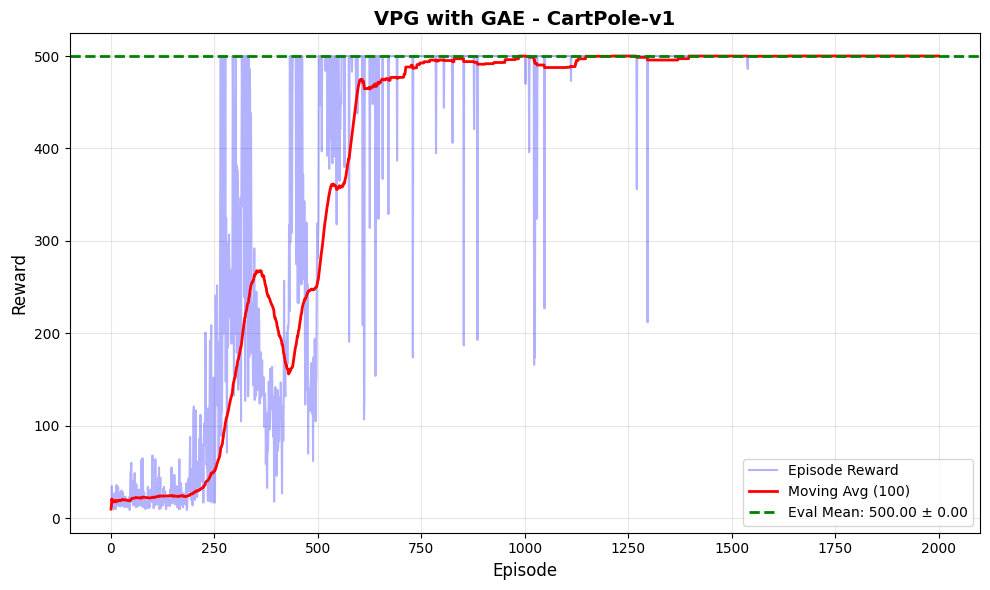


RESULTS SUMMARY - CartPole-v1
Training Time:              327.9s
Final Training Avg (100):   500.00
Evaluation Mean ± Std:      500.00 ± 0.00


################################################################################
# EXPERIMENT: Acrobot-v1
################################################################################


Training VPG with GAE on Acrobot-v1
State dimension: 6
Action dimension: 3
Action space type: Discrete
Policy network: [64, 64]
Value network: [64, 64]
GAE lambda: 0.95



KeyboardInterrupt: 

In [55]:
def run_experiments():
   
    environments = {
          'CartPole-v1': {
            'num_episodes': 2000,
            'lr_policy': 1e-3,
            'lr_value' : 1e-3,
            'max_steps' : 500,
            'hidden_sizes': [64, 64],
            'gamma': 0.99,
            'lam'  : 0.95,
        },
        'Acrobot-v1': {
            'num_episodes': 1500,
            'lr_policy': 3e-4,
            'lr_value' : 1e-3,
            'max_steps' : 500,
            'hidden_sizes': [64, 64],
            'gamma': 0.99,
            'lam'  : 0.95,
        },
        'InvertedPendulum-v5': {
            'num_episodes': 1500,
            'lr_policy': 1e-3,
            'lr_value' : 1e-3,
            'max_steps' : 1000,
            'hidden_sizes': [256, 256],
            'gamma': 0.99,
            'lam'  : 0.97,
        },
      
        'LunarLanderContinuous-v3': {
            'num_episodes': 2000,
            'lr_policy': 3e-4,
            'lr_value' : 1e-3,
            'max_steps' : 1000,
            'hidden_sizes': [256, 256],
            'gamma': 0.99,
            'lam'  : 0.95,
        },
        'HalfCheetah-v5': {
            'num_episodes': 3000,
            'lr_policy': 3e-4,
            'lr_value' : 1e-3,
            'max_steps' : 1000,
            'hidden_sizes': [256, 256],
            'gamma': 0.99,
            'lam'  : 0.97,
        },
    }

    results = {}

    for env_name, cfg in environments.items():
        print(f"\n{'#'*80}")
        print(f"# EXPERIMENT: {env_name}")
        print(f"{'#'*80}\n")

        try:
            t0 = time.time()
            agent, episode_rewards, moving_avg_rewards = train_vpg_gae(
                env_name=env_name,
                num_episodes=cfg['num_episodes'],
                lr_policy=cfg['lr_policy'],
                lr_value=cfg['lr_value'],
                gamma=cfg['gamma'],
                lam=cfg['lam'],
                hidden_sizes_policy=cfg['hidden_sizes'],
                hidden_sizes_value=cfg['hidden_sizes'],
                print_freq=50,
                max_steps=cfg['max_steps'],
            )
            t1 = time.time()

            eval_mean, eval_std = evaluate_agent(
                agent, env_name, num_episodes=20, max_steps=cfg['max_steps']
            )

            plot_path = f'{env_name}_vpg_training.png'
            plot_single_env_results(
                env_name, episode_rewards, moving_avg_rewards, eval_mean, eval_std,
                save_path=plot_path
            )

            print_single_env_summary(
                env_name=env_name,
                final_avg=moving_avg_rewards[-1],
                eval_mean=eval_mean,
                eval_std=eval_std,
                training_time=(t1 - t0),
            )

            results[env_name] = {
                'agent': agent,
                'episode_rewards': episode_rewards,
                'moving_avg_rewards': moving_avg_rewards,
                'eval_mean': eval_mean,
                'eval_std': eval_std,
                'config': cfg
            }

            torch.save(agent.policy.state_dict(), f'{env_name}_vpg_policy.pth')
            torch.save(agent.value_net.state_dict(), f'{env_name}_vpg_value.pth')

        except Exception as e:
            print(f"Error training on {env_name}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

    if len(results) == 0:
        print("\nNo successful experiments to summarize.")
    return results


if __name__ == "__main__":
    print("="*80)
    print("VPG + GAE — MULTI-ENVIRONMENT COMPARISON")
    print("="*80)
    results = run_experiments()
    print("\n" + "="*80)
    print("ALL VPG + GAE EXPERIMENTS COMPLETED")
    print("="*80)
